In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df1=pd.read_csv("processed_data.csv")

target_column= "Class"
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df1, df1[target_column]):
    train_set = df1.loc[train_index]
    test_set = df1.loc[test_index]

print("Train set class distribution:\n", train_set[target_column].value_counts(normalize=True))
print("\nTest set class distribution:\n", test_set[target_column].value_counts(normalize=True))

train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

In [ ]:
train_set = pd.read_csv("train_data.csv")
test_set = pd.read_csv("test_data.csv")
target_column = "Class"

In [ ]:
X_train = train_set.drop(columns=[target_column])
y_train = train_set[target_column]
X_test = test_set.drop(columns=[target_column])
y_test = test_set[target_column]

In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


In [ ]:

num_transformer = SimpleImputer(strategy="median")
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [ ]:
# Apply transformations using ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get new column names after encoding
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_cols = list(num_cols) + list(encoded_cat_cols)

# Convert transformed arrays into DataFrames
X_train = pd.DataFrame(X_train_transformed, columns=all_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=all_cols, index=X_test.index)

print("Preprocessing complete! New shape of X_train:", X_train.shape)

In [79]:
X_train.shape

(2240, 37)

In [78]:
X_test.shape

(560, 37)

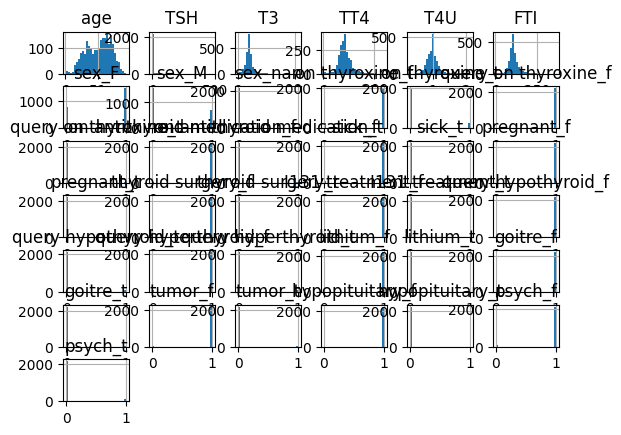

In [81]:
X_train.hist(bins=30)
plt.show()

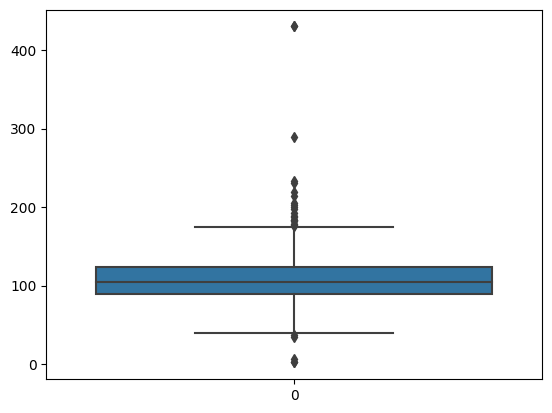

In [82]:
sns.boxplot(X_test["TT4"])
plt.show()

In [ ]:

# Log transform TSH to handle extreme skewness
X_train.loc[:, 'TSH'] = np.log1p(X_train['TSH'])
X_test.loc[:, 'TSH'] = np.log1p(X_test['TSH'])

# Choose scalers based on distribution
scalers = {
    'age': StandardScaler(),
    'TSH': RobustScaler(),   # After log transformation
    'TT4': RobustScaler(),
    'T4U': MinMaxScaler(),
    'FTI': MinMaxScaler(),
    'T3': RobustScaler()
}

# Apply appropriate scaling
for col, scaler in scalers.items():
    X_train[col] = scaler.fit_transform(X_train[[col]]).flatten()
    X_test[col] = scaler.transform(X_test[[col]]).flatten()


In [ ]:
#Check class distribution
print(y_train.value_counts())

In [ ]:
# Plot class distribution
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
minority_class = y_train.value_counts().min()
majority_class = y_train.value_counts().max()

imbalance_ratio = majority_class / minority_class
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")


In [ ]:
pip install imbalanced-learn


In [ ]:


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check new class distribution
print(y_train_resampled.value_counts())

# Plot new class distribution
sns.countplot(x=y_train_resampled)
plt.title("Balanced Class Distribution (After Oversampling)")
plt.show()


In [ ]:
X_train_resampled.shape

In [ ]:
X_train_resampled=pd.DataFrame(data=X_train_resampled, columns=X_train.columns)

In [ ]:
X_train_resampled

In [ ]:
X_train_resampled.isnull().sum()

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# Plot class distribution after SMOTE
sns.countplot(x=y_train_smote)
plt.title("Balanced Class Distribution (After SMOTE)")
plt.show()


 ##SMOTE vs. Random Oversampling

✔ Both techniques balance the dataset, but SMOTE is usually better as it generates synthetic data rather than duplicating samples.

✔ Random Oversampling might cause overfitting, as the model sees the same minority samples multiple times.

✔ SMOTE reduces overfitting risk by creating new synthetic points instead of copying existing ones.

Let's compare SMOTE vs. Random Oversampling by training a model on both resampled datasets and evaluating their performance.

 Steps to Compare


Train a classifier (e.g., Random Forest, Logistic Regression) on:

-Random Oversampling data 

-SMOTE data

Evaluate using:

-Accuracy

-Precision, Recall, F1-score

-Confusion Matrix

Compare results to see which technique performs better.

In [ ]:


# Initialize classifiers
model_ros = RandomForestClassifier(random_state=42)
model_smote = RandomForestClassifier(random_state=42)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train models
model_ros.fit(X_train_ros, y_train_ros)
model_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_ros = model_ros.predict(X_test)
y_pred_smote = model_smote.predict(X_test)

# Evaluate Random Oversampling
print("=== Random Oversampling Results ===")
print(classification_report(y_test, y_pred_ros))
print("Confusion Matrix (Random Oversampling):")
sns.heatmap(confusion_matrix(y_test, y_pred_ros), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Oversampling")
plt.show()

# Evaluate SMOTE
print("=== SMOTE Results ===")
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix (SMOTE):")
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - SMOTE")
plt.show()


In [ ]:


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check new class distribution
print(y_train_resampled.value_counts())

# Plot new class distribution
sns.countplot(x=y_train_resampled)
plt.title("Balanced Class Distribution (After Oversampling)")
plt.show()


SMOTE improved recall for hyperthyroidism (from 72% to 80%) but at the cost of slightly reduced precision.

Hypothyroidism remains a challenge (recall stuck at 50%), meaning the model still struggles with extremely rare cases.

Negative class performance is slightly reduced but remains excellent.

Overall accuracy remains the same (98%), indicating SMOTE didn't drastically change the overall performance but helped with class balance.

1️⃣ we will Use SMOTE for Hypothyroidism + Random Oversampling for Hyperthyroidism
2️⃣ Experiment with XGBoost, Random Forest, and SVM

3️⃣ Evaluate results & fine-tune hyperparameters

In [ ]:
pip install imbalanced-learn xgboost scikit-learn
